In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import numpy.linalg as la
import scipy.linalg as sla
import scipy.sparse as sp
import scipy.sparse.linalg as spla

# Norms

In [3]:
v = np.random.rand(10)
print(v)

p = 5

#clear

normv = 0
for vi in v:
    normv += vi**p
normv = normv**(1/p)
  
print(normv, la.norm(v,p))

[0.6941883  0.34446549 0.16584797 0.79286753 0.8055187  0.22374267
 0.39421691 0.35993428 0.70158379 0.39689181]
1.002903957568391 1.002903957568391


In [3]:
n = 10

A = np.random.rand(n,n)
print(A.shape)

v = np.random.rand(n)
print(v.shape)

p = 2

#clear

#get norm v
normv = 0
for vi in v:
    normv += vi**p
normv = normv**(1/p)

#get norm Av
Av = A@v
normAv = 0
for vi in Av:
    normAv += vi**p
normAv = normAv**(1/p)
 
print(normAv/normv, la.norm(A,2))

(10, 10)
(10,)
4.750681993825184 4.92906067502148


In [4]:
#clear

n = 10

A = np.random.rand(n,n)
print(A.shape)

p = 2

normA = 0

for i in range(100000):

    v = np.random.rand(n)

    #get norm v
    normv = 0
    for vi in v:
        normv += vi**p
    normv = normv**(1/p)

    #get norm Av
    Av = A@v
    normAv = 0
    for vi in Av:
        normAv += vi**p
    normAv = normAv**(1/p)
    
    normAtemp = normAv/normv
    if normAtemp > normA:
        normA = normAtemp


print(normA, la.norm(A,p))

(10, 10)
5.010522943162962 5.030201859185762


# Norms to quantify errors

In [5]:
u = np.array([1,0])
v = np.array([1,0.1])

e = v-u
la.norm(e,2)

0.1

In [6]:
la.norm(v)

1.004987562112089

In [7]:
la.norm(u)

1.0

# Be careful with the default settings

https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html

In [8]:
n = 3

A = np.random.randint(10, size=(n,n))
print(A)

#clear

print(la.norm(A))
print(la.norm(A.flatten()))

print(la.norm(A,2))
print(la.svd(A)[1])

print(la.norm(A,1))
print(A.sum(axis=0))

print(la.norm(A,np.inf))
print(A.sum(axis=1))

[[8 5 7]
 [2 0 1]
 [5 1 1]]
13.038404810405298
13.038404810405298
12.753730981250325
[12.75373098  2.63673594  0.6244755 ]
15.0
[15  6  9]
20.0
[20  3  7]


# Solve Linear System of Equations

![](myfigure.png)

When performing optimization of structural problem, for example to obtain the bridge design above, you may want to use a numerical method called Finite Element Method (you will learn this in a future MP). The optimization will consist of a series of `solve` of the form:
$$ {\bf K} {\bf u} = {\bf F} $$

Here will load the matrix $ {\bf K}$ from a file. The matrix is given in Compressed Sparse Column (CSC) format.

In [9]:
K = sp.load_npz('yourmatrix.npz')
K

<6600x6600 sparse matrix of type '<class 'numpy.float64'>'
	with 105912 stored elements in Compressed Sparse Column format>

We can `spy` the distribution of the non-zero entries of the matrix:

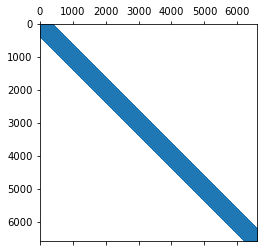

In [10]:
plt.spy(K)
plt.show()

The matrix ${\bf K}$ has a banded format, and it is also symmetric and positive definite. 

In [11]:
Kdense = K.todense()

In [12]:
Kdense.shape

(6600, 6600)

### Solving the linear system of equations using different methods:

In [13]:
F = np.zeros(K.shape[0])
F[1]=-1

#### a) la.solve

In [14]:
u1 = sla.solve(Kdense,F)
u1.shape

(6600,)

#### b) LU factorization

In [15]:
P,L,U = sla.lu(Kdense)
y = sla.solve_triangular(L, np.dot(P.T, F), lower=True)
u2 = sla.solve_triangular(U, y)
u2.shape

(6600,)

#### c) Cholesky factorization

In [16]:
Kcho = sla.cholesky(Kdense)
u3 = sla.cho_solve((Kcho,False),F)
u3.shape

(6600,)

#### d) Sparse solve

In [17]:
u4 = spla.spsolve(K,F)
u4.shape

(6600,)

# What is happening inside "solve"?

Inside "Solve" there are factorization and substitutions. For example, let's think of LU factorization.

We want to solve $Ax = P L U x = b$. We perform the following steps:

1. Factorize $A = P L U$
2. $y \leftarrow \text{solve}\,\, L y = P^Tb$
3. $x \leftarrow \text{solve}\,\, U x = y$

## Why do we split the factorization and substitutions?

In [18]:
F = np.zeros(K.shape[0])
F[1]=-10
F[0]=5

In [19]:
sla.solve(Kdense,F)

array([-459.314442  , -475.51384278, -468.07847515, ...,  119.77705961,
        -11.59014506,  138.47099828])

In [20]:
P, L, U = sla.lu(Kdense)

y = sla.solve_triangular(L, P.T@F, lower=True)

sla.solve_triangular(U, y)

array([-459.314442  , -475.51384278, -468.07847515, ...,  119.77705961,
        -11.59014506,  138.47099828])

In [21]:
#clear
F[1]=10
F[0]=10
y = sla.solve_triangular(L, P.T@F, lower=True)
sla.solve_triangular(U, y)

array([1887.13375621, 1878.39516289, 1860.03769023, ..., -478.84908937,
         46.36058189, -553.53877926])

# Simple example


$$
Ax = \begin{bmatrix}c&1\\-1&1\end{bmatrix}\begin{bmatrix}x_1\\x_2\end{bmatrix}
=
\begin{bmatrix}b_1\\b_2\end{bmatrix}
$$
with an exact solution of
$$
x_{exact} = \begin{bmatrix}1\\1\end{bmatrix}
$$

In [22]:
def myLU(A): 
    M = A.copy()
    for i in range(A.shape[0]):
        M[i+1:,i] = M[i+1:,i]/M[i,i]
        M[i+1:,i+1:] -= np.outer(M[i+1:,i],M[i,i+1:]) 
    return M

In [23]:
# Creating the arrays
c = 1e-16
A = np.array([[c, 1.], [-1, 1]])
# xx is the exact solution
xx = np.array([1,1])
b = A.dot(xx)

# Comput the LU
M = myLU(A)
L = np.tril(M,-1) + np.eye(2,2)
U = np.triu(M)

# Solve
# x is the numerical (xhat)
y = sla.solve_triangular(L, b, lower=True)
x = sla.solve_triangular(U, y)


print("Exact solution = ", xx)

print("Computed solution = ",x)

print("Error = ", la.norm(xx-x))


Exact solution =  [1 1]
Computed solution =  [0. 1.]
Error =  1.0


Is the matrix A singular?

A) YES

B) NO


In [24]:
#clear

# Creating the arrays
c = 1e-16
A = np.array([[c, 1.], [-1, 1]])
# xx is the exact solution
xx = np.array([1,1])
b = A.dot(xx)

# P,L,U = sla.lu(A)
# y = sla.solve_triangular(L, P.T@b, lower=True)
# x = sla.solve_triangular(U, y)

x = la.solve(A,b)


print("Exact solution = ", xx)

print("Computed solution = ",x)

print("Error = ", la.norm(xx-x))

Exact solution =  [1 1]
Computed solution =  [1. 1.]
Error =  0.0


In [25]:
Asing = np.array([[4,6],[2,3]])
print(la.det(Asing))
b = np.random.rand(2)

0.0


In [29]:

P,L,U = sla.lu(Asing)

# y = sla.solve_triangular(L, P.T@b, lower=True)

# x = sla.solve_triangular(U, y)

# x = la.solve(Asing,b)



LinAlgError: singular matrix: resolution failed at diagonal 1